# Active Session 3: Dynamic Mode Decomposition: PyDMD exercise

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cihan-ates/data-driven-engineering/blob/master/DDE_II_Advanced_Topics/Lecture%204/Lecture_4.ipynb)


#Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





## Installing the PyDMD

PyDMD requires requires numpy, scipy, matplotlib, sphinx and compatible with both Python 2.7 and Python 3.6. It can be installed using pip very practically:

In [1]:
#Instructions: https://mathlab.github.io/PyDMD/
!pip install pydmd

In [2]:
# Loading libraries:
#
#Fundamentals
import numpy as np
import pandas as pd
import os
# Aux. libs:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from matplotlib.cm import rainbow
from scipy.io import loadmat
import itertools
import scipy
import scipy.integrate
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt

#Other models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet

# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm
import matplotlib as mpl
import time
from ipywidgets import interact_manual, interact, interactive, FloatSlider

In [3]:
#
#ML libraries
from pydmd import DMD
from pydmd import FbDMD

# Exploring PyDMD

The DMD method originated from the fluid dynamics community as a method to decompose transient complex flows into "modes" based on spatiotemporal coherent structures. The method can be interpreted as a combination of (i) PCA in the sense of spatial dimensionality reduction and (ii) frequecy-based temporal analysis such as Fourier transformations. Similar to PCA, we will get components -- now called modes -- and we will look how these modes evolve in time. The objective is to ease the analysis of coherent structures observed in high dimensional systems in a different coordinate system. This temporal behaviour is typically analyzed as temporal frequency, possibly with a growth or decay rate. 

DMD is algorithmically a regression of data onto locally linear dynamics. it is very simple to perform and it makes almost no assumptions about the underlying system. Potential applications are:

+ diagnostic tool to characterize complex fluid flows,
+ state estimation and future-state prediction,
+ ultimately, data-driven approach to control.

## Lets start with the base model

Lets see the implementation of a very basic, text book example. We will have 2 signals, which will have different frequencies in time, merging into a more complex output:

$\
f_1(x,t) = \text{sech}(x)\exp(i1.618t)
$

$\
f_2(x,t) = \tanh(x)\exp(i0.618t)
$

Above you can follow the spatial and temporal dependencies explicitly, which we would not know in a real, data driven case. Lets generate our data from these functions:


In [39]:
# Function definitions:
def f1(t,x): 
    return 1./np.cosh(x)*np.exp(1.618j*t)
def f2(t,x):
    return 1*np.tanh(x)*np.exp(0.618j*t)
#----------------------------------
#Creating the independent variables:
x = np.linspace(-6, 6, 400)
t = np.linspace(0, 4*np.pi, 200)
# creating coordinate matrices from coordinate vectors:
tgrid, xgrid = np.meshgrid(t,x)
# calling the functions:
X1 = f1(tgrid, xgrid)
X2 = f2(tgrid, xgrid)
X = X1 + X2

In [40]:
print(X.shape)

(400, 200)


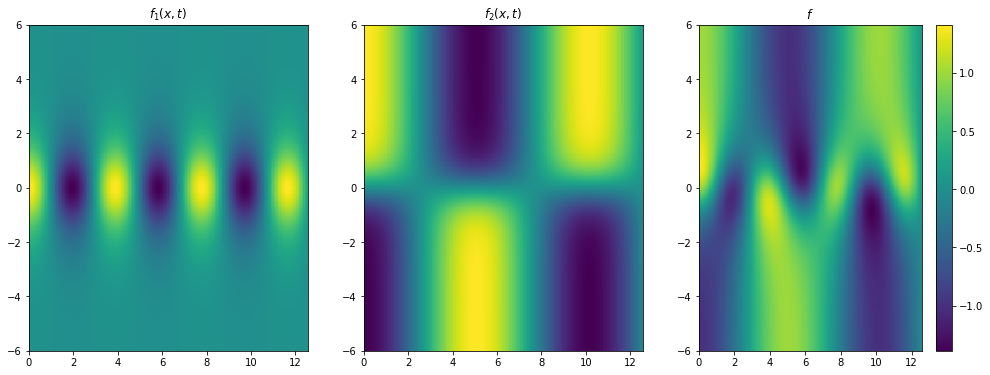

In [41]:
# Plotting the individual and the combined functions:
titles = ['$f_1(x,t)$', '$f_2(x,t)$', '$f$']
data = [X1, X2, X]

fig = plt.figure(figsize=(17,6))
for n, title, d in zip(range(131,134), titles, data):
    plt.subplot(n)
    plt.pcolor(tgrid, xgrid, d.real)
    plt.title(title)
plt.colorbar()
plt.show() 

Note that we have t in the horizontal axis and X values on the vertical axis. 

Lets apply the DMD algorithm we discussed:

In [42]:
#https://mathlab.github.io/PyDMD/dmdbase.html
#
#Hyperparameters:
#----------------
#the rank for the truncation; If 0, the method computes the optimal rank and uses it for truncation; 
#if positive interger, the method uses the argument for the truncation; 
#if float between 0 and 1, the rank is the number of the biggest singular values that are needed 
#to reach the ‘energy’ specified by svd_rank.
#----------------
svd_rank=2
#Calling the model:
dmd = DMD(svd_rank=svd_rank)
# 'Training' the model:Compute the Dynamic Modes Decomposition to the input data.
dmd.fit(X)

/usr/local/lib/python3.7/dist-packages/pydmd/dmdbase.py:329: UserWarning: Input data matrix X has condition number 6.203628114921956e+17. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  .format(cond_number))




The dmd object contains the information about the decomposition:

https://mathlab.github.io/PyDMD/dmdbase.html

`modes`: Get the matrix containing the DMD modes, stored by column

`dynamics`: Get the time evolution of each mode.

`eigs`: Plot the eigenvalues. :param bool show_axes: if True, the axes will be showed in the plot.

`reconstructed_data`: Get the reconstructed data.

`plot_modes_2D`: Plot the DMD Modes.

`plot_eigs`: Plot the eigenvalues. :param bool show_axes: if True, the axes will be showed in the plot.

**Note:**

The eigen values helps us to determine whether the modes are stable or not: 

+ if an eigenvalue is on the unit circle, the corresponding mode will be stable; 

+ if an eigenvalue is inside or outside the unit circle, the mode will converge or diverge, respectively. Let see our case:

In [43]:
# Getting the numerical values:
#https://mathlab.github.io/PyDMD/_summaries/pydmd.dmdbase.DMDBase.eigs.html
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

Eigenvalue (0.9992386130812271+0.039015306323361205j): distance from unit circle 0.0
Eigenvalue (0.9947848984321274+0.10199512660603323j): distance from unit circle 1.3322676295501878e-15


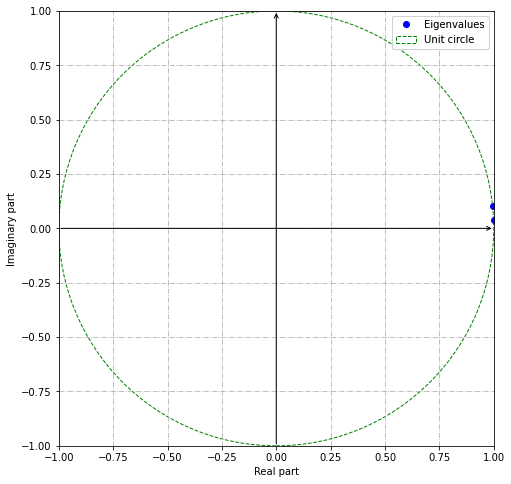

In [44]:
#Plotting eig values:
#https://mathlab.github.io/PyDMD/_summaries/pydmd.dmdbase.DMDBase.plot_eigs.html
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

Lets see modes and the dynamics:


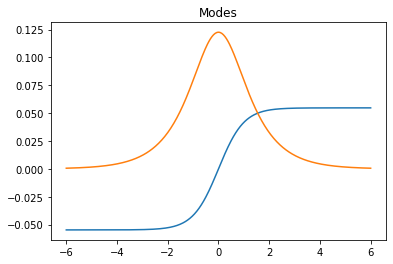

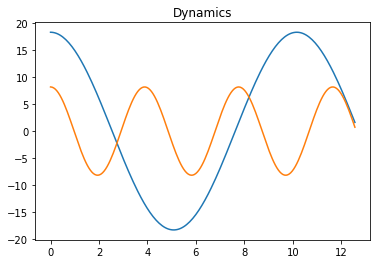

In [45]:
# Looking into the modes:
#https://mathlab.github.io/PyDMD/_summaries/pydmd.dmdbase.DMDBase.modes.html
#Since we typically have many, lets plot them together in a for loop.
for mode in dmd.modes.T:
    plt.plot(x, mode.real)
    plt.title('Modes')
plt.show()
# Looking into the dynamics:
#https://mathlab.github.io/PyDMD/_summaries/pydmd.dmdbase.DMDBase.dynamics.html
# getting us the time evalution of the modes
for dynamic in dmd.dynamics:
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
plt.show()



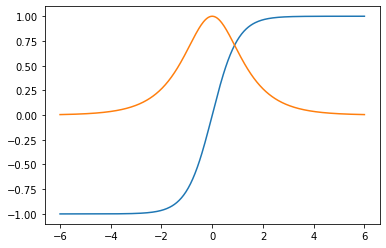

In [46]:
#Lets remember our basic functions!
plt.plot(x, np.tanh(x))
plt.plot(x, 1./np.cosh(x))

As the next step, we can reconstruct dynamics of the system as the product of modes and dynamics.

In [66]:
dy =dmd.dynamics[0].reshape(1,-1)

In [68]:
#Getting the modes
DM1 = dmd.modes.T[0].reshape(-1,1).dot(dmd.dynamics[0].reshape(1,-1))
DM2 = dmd.modes.T[1].reshape(-1,1).dot(dmd.dynamics[1].reshape(1,-1))

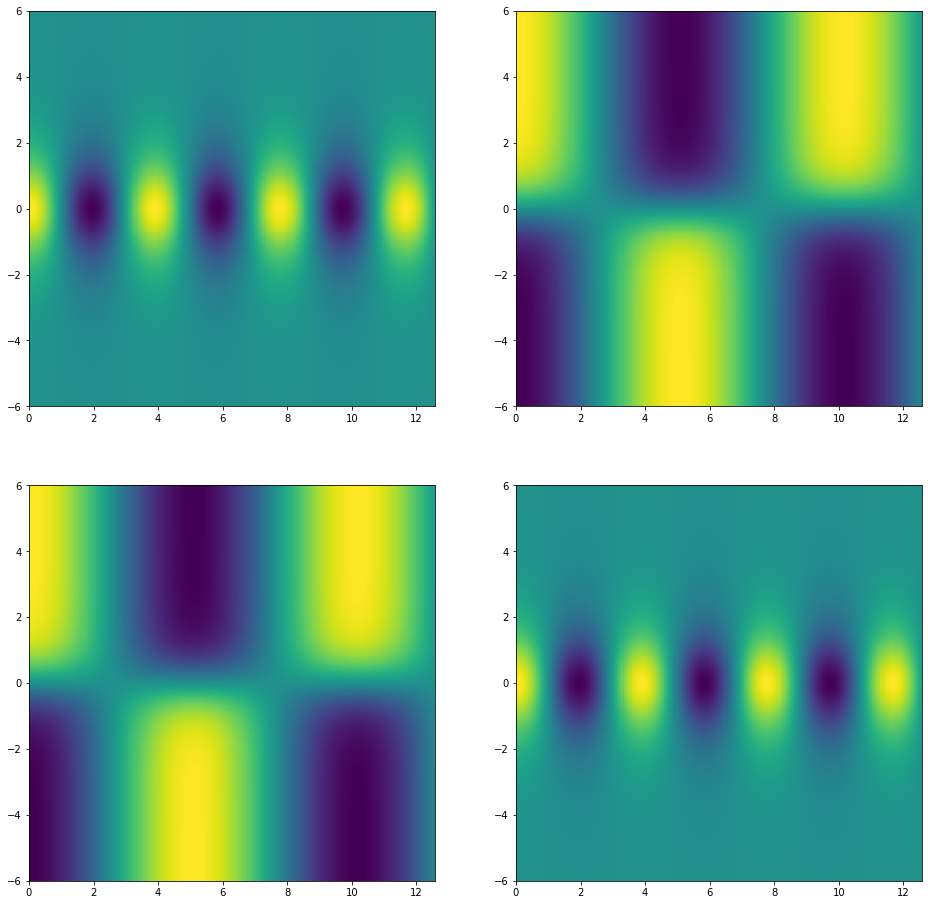

In [73]:
# Data reconstruction:
#https://mathlab.github.io/PyDMD/_summaries/pydmd.dmdbase.DMDBase.reconstructed_data.html
#
#Plotting next to the previous figure
# Plotting the individual and the combined functions:
titles = ['$f_1(x,t)$', '$f_2(x,t)$','Mode 1','Mode 2']
data = [X1, X2,DM1, DM2, dmd.modes]
fig = plt.figure(figsize=(16,16))
for n, title, d in zip(range(221,225), titles, data):
    plt.subplot(n)
    plt.pcolor(tgrid, xgrid, d.real)   
plt.show() 


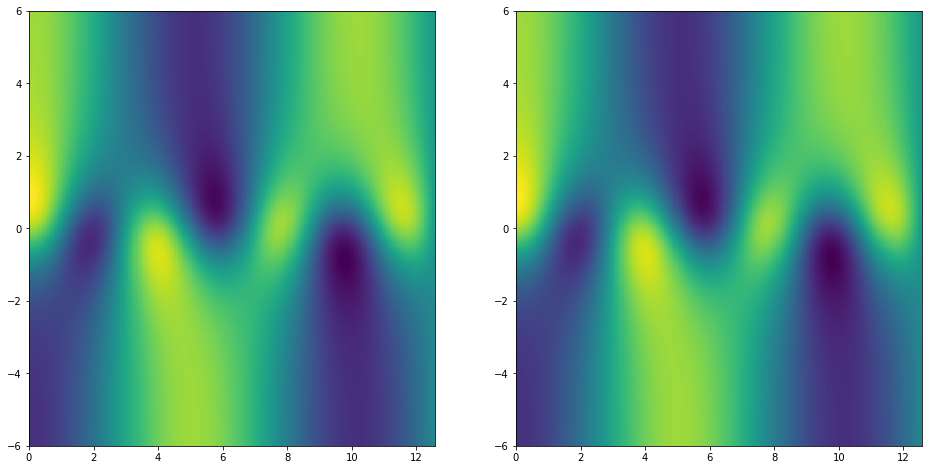

In [74]:
# Data reconstruction:
#https://mathlab.github.io/PyDMD/_summaries/pydmd.dmdbase.DMDBase.reconstructed_data.html
#
#Plotting next to the previous figure
# Plotting the individual and the combined functions:
titles = ['$f$', 'Reconstructed']
data = [X, dmd.reconstructed_data.real]
fig = plt.figure(figsize=(16,8))
for n, title, d in zip(range(121,123), titles, data):
    plt.subplot(n)
    plt.pcolor(tgrid, xgrid, d.real)   
plt.show() 

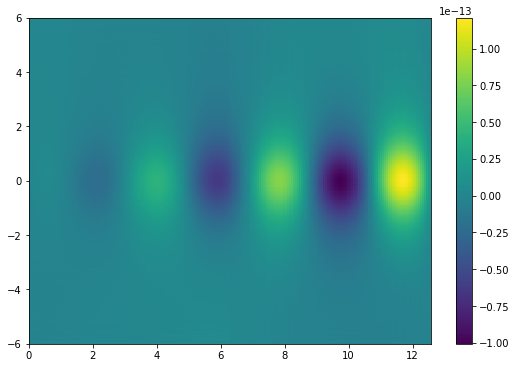

In [13]:
#Error in reconstruction
fig = plt.figure(figsize=(9,6))
plt.pcolor(tgrid,xgrid,(X-dmd.reconstructed_data).real)
fig = plt.colorbar()

We see that there are some minor errors but the reconstruction is very well. 

The next question is; can we do better? Can we forecast into the future with the learnt dynamics? For that,lets look at a more complex problem.

# Advanced tuning and forecasting with DMD

Here we will crate a temporal, 2D oscillation with noise, to make things more difficult for DMD:

Here is the ground truth:

$\
f(x,y,t) := \text{senh}(x) * \text{senh}(y)*1.2\text{i}^{-t}
$


In [14]:
#Creating the grid:
x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
x1grid, x2grid = np.meshgrid(x1, x2)
# temporal data
time = np.linspace(0, 5, 20)
# getting the f over the grid points:
data = [2/np.cosh(x1grid)/np.cosh(x2grid)*(1.2j**-t) for t in time]
# creating random noise:
noise = [np.random.normal(0.0, 0.33, size=x1grid.shape) for t in time]
# combining the true values and the noise:
snapshots = [d+n for d,n in zip(data, noise)]


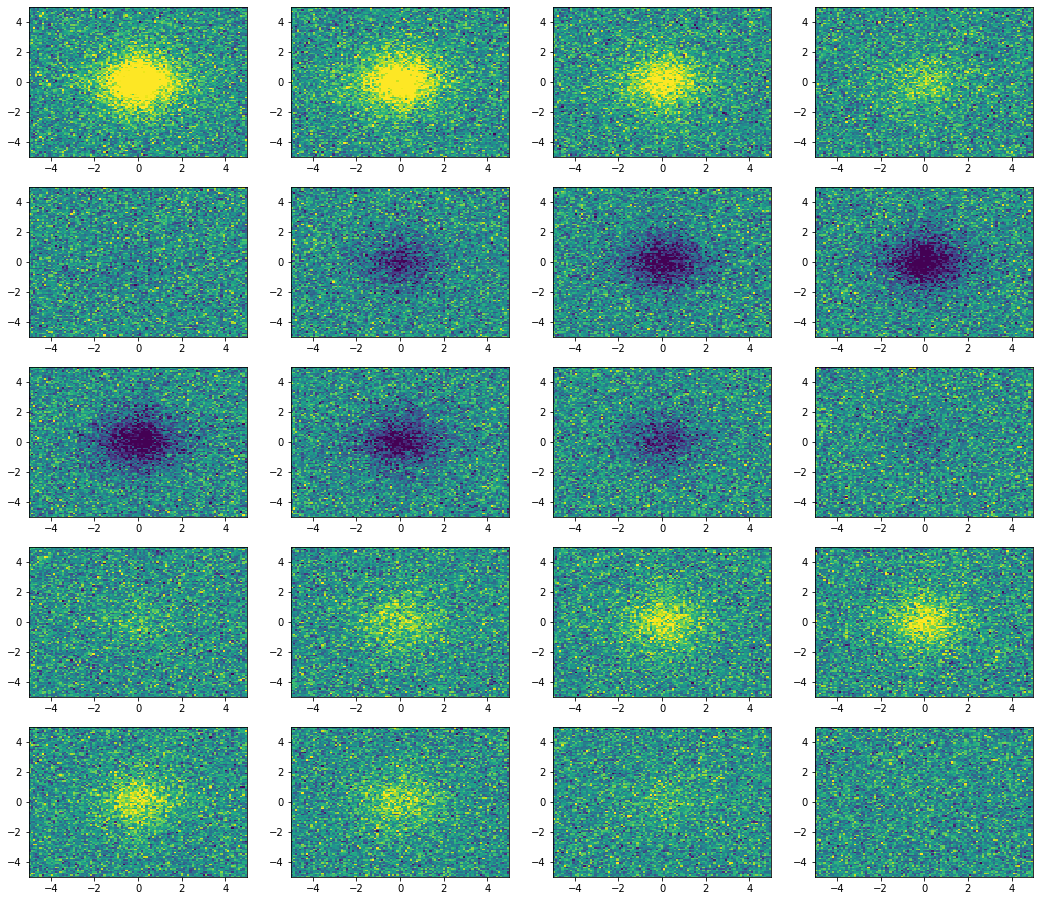

In [15]:
# Lets see how it looks like:
fig = plt.figure(figsize=(18,16))
for id_subplot, snapshot in enumerate(snapshots, start=1):
    plt.subplot(5, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.real, vmin=-1, vmax=1)

## Applying DMD to the snapshots

Okay, now the magic trick! We will apply again the DMD on the dataset. Now lets epand our control over hyperparameters!

In [16]:
#https://mathlab.github.io/PyDMD/dmdbase.html
#
#Hyperparameters:
#class DMDBase(svd_rank=0, tlsq_rank=0, exact=False, opt=False, rescale_mode=None, forward_backward=False, sorted_eigs=False)
#----------------
#the rank for the truncation; If 0, the method computes the optimal rank and uses it for truncation; 
#if positive interger, the method uses the argument for the truncation; 
#if float between 0 and 1, the rank is the number of the biggest singular values that are needed 
#to reach the ‘energy’ specified by svd_rank.
svd_rank=1
#----------------
#tlsq_rank (int) – rank truncation computing Total Least Square. Default is 0, that means no truncation.
# we can use it to remove or reduce the noise in the data.
tlsq_rank=2
#----------------
#exact (bool) – flag to compute either exact DMD or projected DMD. Default is False.
exact = True
#----------------
#opt (bool or int) – If True, amplitudes are computed like in optimized DMD 
#(see https://mathlab.github.io/PyDMD/_summaries/pydmd.dmdbase.DMDBase._compute_amplitudes.html) 
#If False, amplitudes are computed following the standard algorithm
opt = True
#----------------
#Calling the model:
dmd = DMD(svd_rank=svd_rank, tlsq_rank=tlsq_rank, exact=exact, opt=opt)
# 'Training' the model:Compute the Dynamic Modes Decomposition to the input data.
dmd.fit(snapshots)

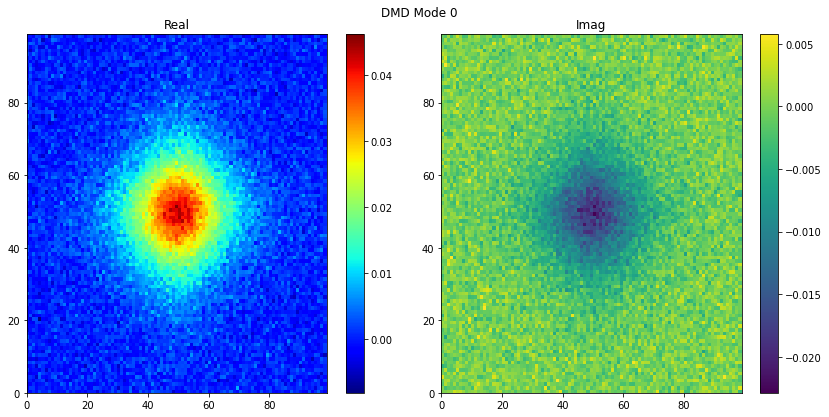

In [17]:
#Plotting the modes in 2D:
#This is already available!
dmd.plot_modes_2D(figsize=(12,6))

### How to define the rank?

We have to options to select the rank: we can either set it to be decided automatically by setting `svd_rank` to zero. Alternatively, we can check the relative importance of SVDs and set it by ourselves, like we did in 'Clustering' algorithms in DDE-1.


In [18]:
# Data formatting & calculating svds:
#we will use linear algebra functions under scipy and call svd values, which compute singular values of a given matrix.
data = np.array([snapshot.flatten() for snapshot in snapshots]).T
data.shape

(10000, 20)

In [19]:
svd_ranks = scipy.linalg.svdvals(data)
svd_ranks

array([125.28564687,  34.07198385,  33.94672045,  33.69002539,
        33.57489088,  33.49565333,  33.32795426,  33.27412692,
        33.21047797,  33.12323239,  32.99759296,  32.8691739 ,
        32.71839946,  32.6419595 ,  32.51467475,  32.37991245,
        32.22604304,  32.04940536,  31.93570898,  31.83054866])

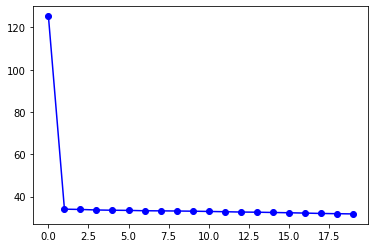

In [20]:
#Lets plot them: we will clearly see an elbow
fig = plt.plot(svd_ranks,'-bo')

In [21]:
rec = dmd.reconstructed_data
rec.shape

(10000, 20)

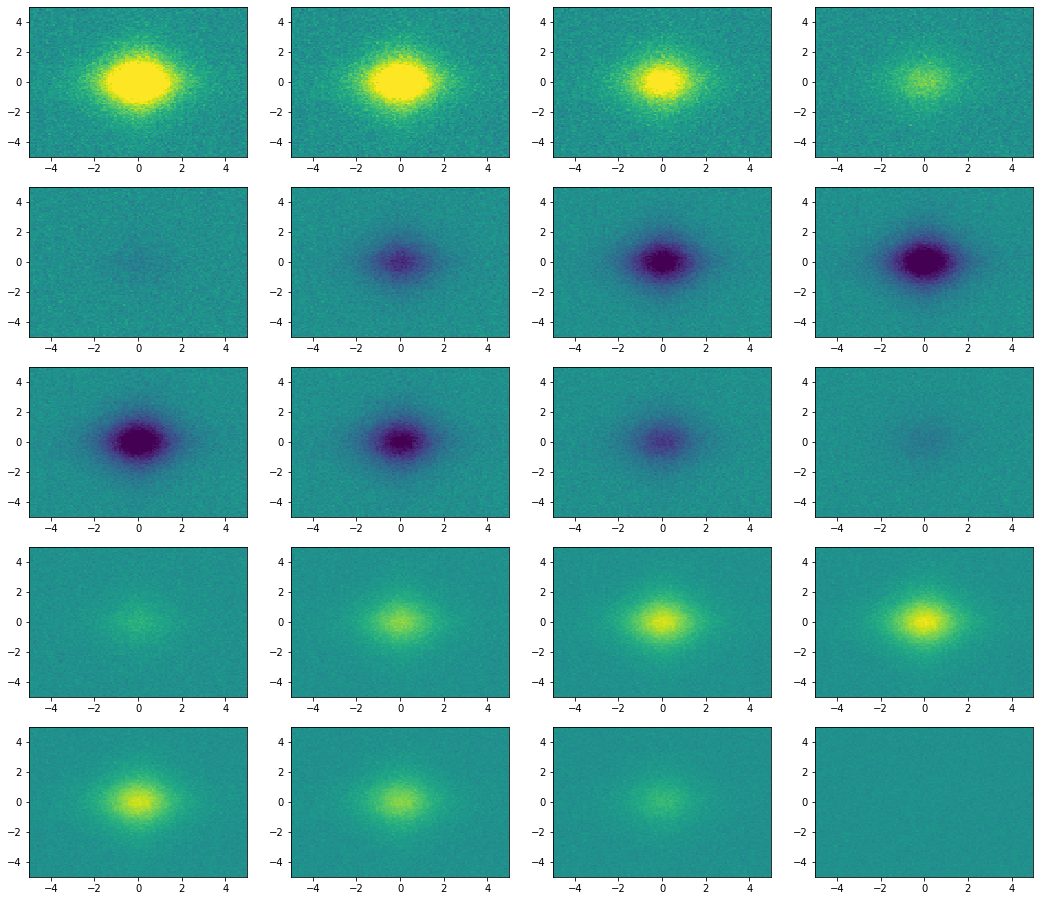

In [22]:
# So it was not a bad idea to use svd_rank as 1. As the next step, lets see the reconstructed data.
# We will plot the instances as we did before. We will only replace the data with the "dmd.reconstructed_data"
#which is "rec"
fig = plt.figure(figsize=(18,16))
for id_subplot, snapshot in enumerate(rec.T, start=1):
    plt.subplot(5, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.reshape(x1grid.shape).real, vmin=-1, vmax=1)


If you compare it to the figure above, you would see that the noise is reduced drastically. Since we have figured out the underlying dynamics of the system, now we can create more data than the initial set. In this respect, DMD can be interpreted as a generative model.

In [23]:
#Original data set shape
print("Original data set shape: {}".format(dmd.reconstructed_data.shape))
#-----------------------------------------------------------------------------
# Generating data: see variables under:
#https://mathlab.github.io/PyDMD/dmdbase.html
#-----------------------------------------------------------------------------
#dmd_time is a dictionary that contains information about the time window 
# where the system is reconstructed:
#        t0 is the time of the first approximated solution;
#        tend is the time of the last approximated solution;
#        dt is the delta time between the approximated solutions.
#-----------------------------------------------------------------------------
dmd.dmd_time['dt'] *= 0.20
dmd.dmd_time['tend'] *= 2
print("Modified data shape: {}".format(dmd.reconstructed_data.shape))

Original data set shape: (10000, 20)
Modified data shape: (10000, 191)


191


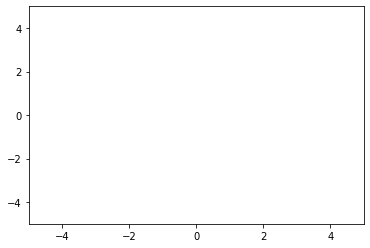

In [24]:
# Now lets take the advantage of using ipython and create an video from the images we generated:
# base figure
fig = plt.figure()
# generating data
dmd_states = [state.reshape(x1grid.shape) for state in dmd.reconstructed_data.T]
print(len(dmd_states))
# Hidden nested loop: 
frames = [[plt.pcolor(x1grid, x2grid, state.real, vmin=-1, vmax=1)] for state in dmd_states ]
#Note that before creating an instance, all plotting should have taken place and the relevant artists should be saved
#ArtistAnimation(fig, artists, *args, **kwargs)
#interval: Delay between frames in milliseconds
#blit : bool, optional. Controls whether blitting is used to optimize drawing. Defaults to False
animated_results = animation.ArtistAnimation(fig, frames, interval=70, repeat=False)


In [25]:
HTML(animated_results.to_html5_video())

### Global evaluation of the forecasting

Lets simplfy the data with integration over the surface and see the evalaution of the pulsations in time. It may give us an idea about the overall performance of the reconstruction.

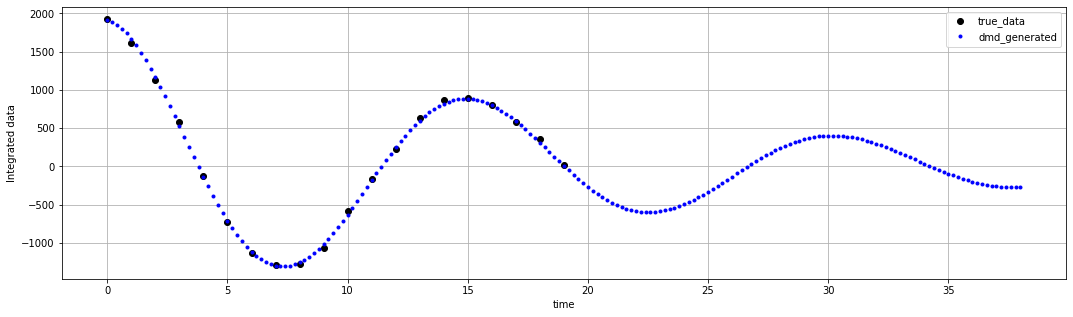

In [26]:
#Picking an integration scheme; 2D => 1D plot
compute_integral = scipy.integrate.simps

true_data = [compute_integral(compute_integral(snapshot)).real for snapshot in snapshots]
dmd_generated = [compute_integral(compute_integral(state)).real for state in dmd_states]

figure = plt.figure(figsize=(18, 5))
plt.plot(dmd.original_timesteps, true_data, 'ko', linewidth=3, label='true_data')
plt.plot(dmd.dmd_timesteps, dmd_generated, 'b.', label='dmd_generated')
plt.ylabel('Integrated data')
plt.xlabel('time')
plt.grid()
leg = plt.legend()

# More fun example: flow around the buildings

This time we will look at a single phase flow problem. The case is from the tutorial library of OpenFOAM:

+ https://github.com/OpenFOAM/OpenFOAM-5.x/tree/master/tutorials/incompressible/simpleFoam/windAroundBuildings

+ https://www.youtube.com/watch?v=LCjYMtcFB2k

The flow is incompressible and turbulent, solved by using  the Reynolds-averaged Navier Stokes equations with the k-ϵ model. 

Data is uploaded manually:

In [27]:
# Getting the flow field data:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [28]:
#unzipping the file:
!unzip data.zip
!ls data/

Archive:  data.zip
   creating: data/
  inflating: data/velocity0.20.csv   
  inflating: data/velocity0.21.csv   
  inflating: data/velocity0.22.csv   
  inflating: data/velocity0.23.csv   
  inflating: data/velocity0.24.csv   
  inflating: data/velocity0.25.csv   
  inflating: data/velocity0.26.csv   
  inflating: data/velocity0.27.csv   
  inflating: data/velocity0.28.csv   
  inflating: data/velocity0.29.csv   
  inflating: data/velocity0.30.csv   
  inflating: data/velocity0.31.csv   
  inflating: data/velocity0.32.csv   
  inflating: data/velocity0.33.csv   
  inflating: data/velocity0.34.csv   
  inflating: data/velocity0.35.csv   
  inflating: data/velocity0.36.csv   
  inflating: data/velocity0.37.csv   
  inflating: data/velocity0.38.csv   
  inflating: data/velocity0.39.csv   
velocity0.20.csv  velocity0.25.csv  velocity0.30.csv  velocity0.35.csv
velocity0.21.csv  velocity0.26.csv  velocity0.31.csv  velocity0.36.csv
velocity0.22.csv  velocity0.27.csv  velocity0.32.csv  veloci

In [29]:
sample_case = pd.read_csv("./data/velocity0.20.csv")
sample_case.head()

,U:0,U:1,U:2,epsilon,k,nut,p,Points:0,Points:1,Points:2
0,10.015,-0.04198,0.006479,0.100590,1.4564,0.12720,125.57,-20.0000,-50.0,0
1,10.071,-0.08055,0.016677,0.097170,1.4218,0.12577,125.18,-5.9747,-50.0,0
2,10.244,-0.15770,0.038578,0.090140,1.3545,0.12296,123.68,8.0399,-50.0,0
3,10.537,-0.22775,0.060424,0.082888,1.2830,0.11989,120.68,22.0410,-50.0,0
4,10.937,-0.27641,0.075055,0.078488,1.2293,0.11753,116.21,36.0290,-50.0,0


In [30]:
# This is a 2D simulation, and we will look at one of the velocity components.
# If you would like to plot the velocity field, you need to be careful though. 
# The simulation was performed on unstructured grid hence we either need to remap the data
# on regular grid or simply used scatter plot. Second one is much easier!
#-----------------------------------------
# as a note, you may save the data in a way that you can visualize in Paraview etc. 
# if working on local machines, such as hdf5 format. 
#-----------------------------------------
#Lets get the data similar to previous cases. This time from data.
#     read data files from 20 to 39. names are formatted and we will pass a format accordingly.
#     we will also skip the header, which can be seen in the data frame above.
#     we will collect the first velocity component; 0th column.
#     U:0 from all files are stored under snapshots.
snapshots = [np.genfromtxt('data/velocity0.{}.csv'.format(i), delimiter=',', skip_header=1)[:, 0] 
             for i in range(20, 40)]
#Next step: we will need the coordinates. we will get them from the last 3rd and second columns.
#any file would do.
pts = np.genfromtxt('data/velocity0.20.csv', delimiter=',', skip_header=1)[:, -3:-1]

In [31]:
# checking...
print(len(snapshots))

20


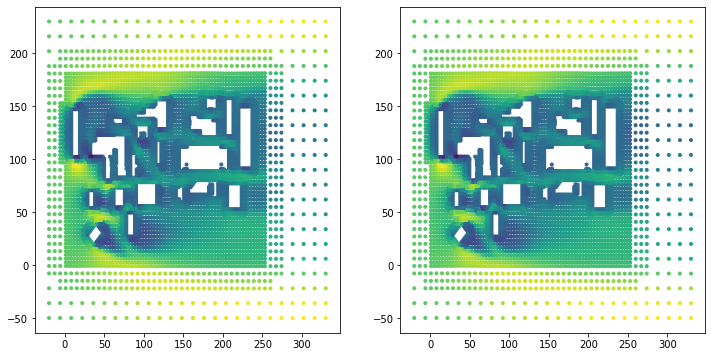

In [32]:
# Plotting the velocity data:
plt.figure(figsize=(12, 6))
for i, snapshot in enumerate(snapshots[:2], start=1):
    plt.subplot(1, 2, i)
    plt.scatter(pts[:, 0], pts[:, 1], c=snapshot, marker='.')
plt.show()



## Forward-Backward DMD

Like any data processing technique, DMD's usefulness is limited by its ability to extract real and accurate dynamical features from noise-corrupted data. In order to remove numerical noise,  here we will apply a remedy called Forward-Backward DMD:

https://arxiv.org/abs/1507.02264

In [33]:
#FbDMD: It has the same attributes and methods of the DMD class. 
#------------------------------------------------------------
#class FbDMD(svd_rank=0, tlsq_rank=0, exact=False, opt=False, rescale_mode=None, sorted_eigs=False)
#https://mathlab.github.io/PyDMD/fbdmd.html
# forward-backward version reduces the error by computing the low-rank linear operator
# as the square root of the product between the operator for the forward evolution and 
# the operator for the backward evolution.
##------------------------------------------------------------
#Create object
fbdmd = FbDMD(exact=True)
#'Fitting':
fbdmd.fit(snapshots)
fbdmd.reconstructed_data.shape

(7219, 20)

In [34]:
#Lets see how much it is better than good old DMD. We can check the eigen values of both method:

# Good-old-DMD:
dmd = DMD(exact=True)
dmd.fit(snapshots)
print('[ DMD ] Total distance between eigenvalues and unit circle: {}'.format(
    np.sum(np.abs(dmd.eigs.real**2 + dmd.eigs.imag**2 - 1))
))
print('[FbDMD] Total distance between eigenvalues and unit circle: {}'.format(
    np.sum(np.abs(fbdmd.eigs.real**2 + fbdmd.eigs.imag**2 - 1))
))

[ DMD ] Total distance between eigenvalues and unit circle: 1.5803050385075275
[FbDMD] Total distance between eigenvalues and unit circle: 0.897720000699536


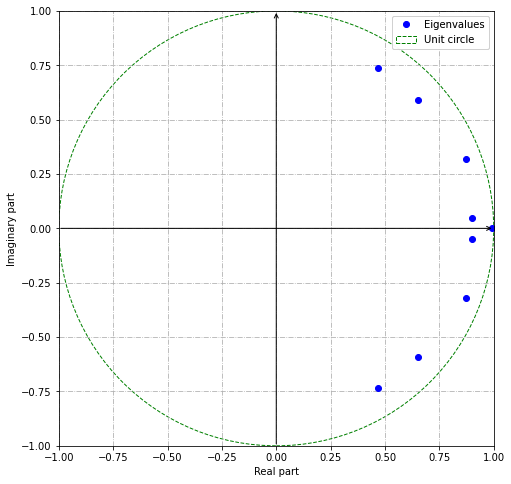

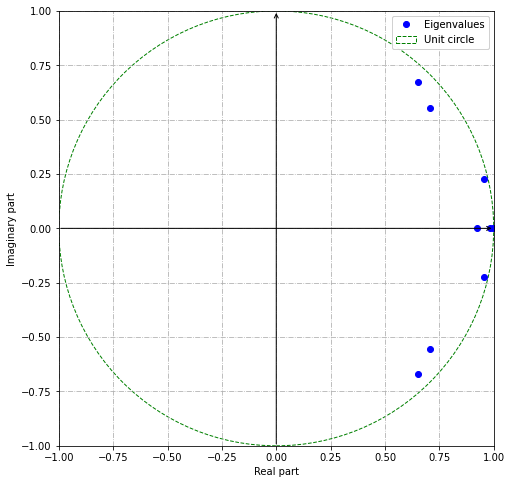

In [35]:
#Plotting the eigen values on unit circle:
dmd.plot_eigs()
fbdmd.plot_eigs()



Lets do the same trick for generating new data and creating a video out of it:

In [36]:
#Lets do the same trick:
print("Original data set shape: {}".format(fbdmd.reconstructed_data.shape))
#-----------------------------------------------------------------------------
# Generating data: see variables under:
#https://mathlab.github.io/PyDMD/dmdbase.html
#-----------------------------------------------------------------------------
#dmd_time is a dictionary that contains information about the time window 
# where the system is reconstructed:
#        t0 is the time of the first approximated solution;
#        tend is the time of the last approximated solution;
#        dt is the delta time between the approximated solutions.
#-----------------------------------------------------------------------------
fbdmd.dmd_time['dt'] *= 0.20
fbdmd.dmd_time['tend'] *= 4
print("Modified data shape: {}".format(fbdmd.reconstructed_data.shape))

Original data set shape: (7219, 20)
Modified data shape: (7219, 381)


381


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


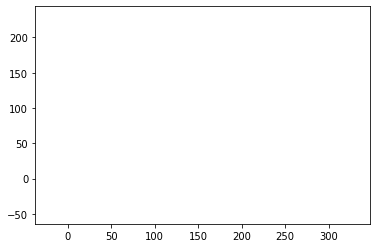

In [37]:
# Now lets take the advantage of using ipython and create an video from the images we generated:
# base figure
fig = plt.figure()
# generating data
dmd_states = [state.reshape(7219) for state in fbdmd.reconstructed_data.T]
print(len(dmd_states))
# Hidden nested loop: 
frames = [[plt.scatter(pts[:, 0], pts[:, 1], c=state, marker='.')] for state in dmd_states ]
#Note that before creating an instance, all plotting should have taken place and the relevant artists should be saved
#ArtistAnimation(fig, artists, *args, **kwargs)
#interval: Delay between frames in milliseconds
#blit : bool, optional. Controls whether blitting is used to optimize drawing. Defaults to False
animated_results_2 = animation.ArtistAnimation(fig, frames, interval=70, repeat=False)


In [38]:
HTML(animated_results_2.to_html5_video())

# References

+ DMD:

https://www.youtube.com/watch?v=sQvrK8AGCAo

https://www.youtube.com/watch?v=wheHQAhJWco

http://www.pyrunner.com/weblog/2016/07/25/dmd-python/

https://www.youtube.com/watch?v=xAYimi7x4Lc

+ PyDMD:

https://mathlab.github.io/PyDMD/index.html

+ Multiresolution DMD:

https://epubs.siam.org/doi/pdf/10.1137/15M1023543

http://www.pyrunner.com/weblog/2016/08/05/mrdmd-python/

+ Sparsity-promoting DMD

http://www.pyrunner.com/weblog/2016/08/03/spdmd-python/


+ Compressed dynamic mode decomposition

https://link.springer.com/article/10.1007/s11554-016-0655-2

https://mathlab.github.io/PyDMD/tutorial4cdmd.html

